**Human Connectome Project: resting state fMRI**

n_subjects: `812`  
n_timepoints: `4800` x 0.75s = 3600s = 60min  
n_regions: `15, 25, 50, 100, 300`  

regions defined by decomposing group-level ICA maps at various spatial scales

timeseries preprocessing:
1. highpass filtered
2. mean-centered
3. removal of phyiological + motion confounds using linear regression:  
    ICA noise components classified by FIX algorithm +   24 head motion parameters

/var/folders/kk/_kp50ntn3xb5_kv9_m3q3sw80000gn/T/ipykernel_1712/3563945009.py:17: RuntimeWarning: overflow encountered in exp
  return np.exp(-x / tau)
/usr/local/Caskroom/miniconda/base/envs/fmri-timescales/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


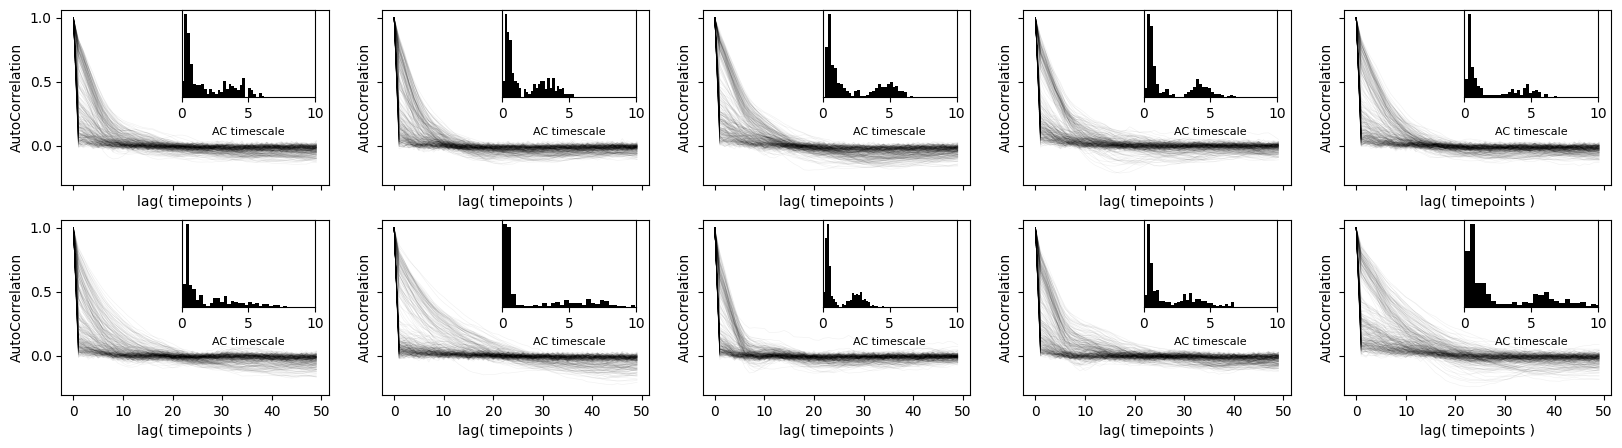

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neurodsp import spectral
from nilearn import plotting
from scipy.optimize import curve_fit

from src import acf_utils


def f(x, tau):
    """exponential decay function for estimating ACF parameters"""
    return np.exp(-x / tau)


def calc_timescale(X_acf, n_timepoints):
    """calculate the timescale for each timeseries/region"""
    x = np.arange(n_timepoints)
    return np.array([curve_fit(f, x, y)[0].squeeze() for y in X_acf])


n_subjects, n_regions, n_timepoints = 10, 300, 4800
sampling_rate = 1 / 0.75
Xs = np.load("./data/nsubjects-10_nregions-300_hcp.npy")

fig, axs = plt.subplots(2, 5, figsize=(20, 5), sharex=True, sharey=True)
axs = axs.flatten()  # type: ignore

for X, ax in zip(Xs, axs):
    """plot the ACF per region + the distribution of timescales across regions"""

    X_acf = acf_utils.acf_fft(X, n_timepoints)
    X_timescale = calc_timescale(X_acf, n_timepoints)

    ax.plot(X_acf[:, :50].T, alpha=0.05, c="k", lw=0.5)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel("lag( timepoints )")
    ax.set_ylabel("AutoCorrelation")

    inset_ax = ax.inset_axes([0.45, 0.5, 0.5, 0.5])
    inset_ax.hist(X_timescale, bins=30, density=True, color="k")
    inset_ax.set_yticks([])
    inset_ax.set_xlim([0, 10])
    inset_ax.set_xlabel("AC timescale", fontsize=8)


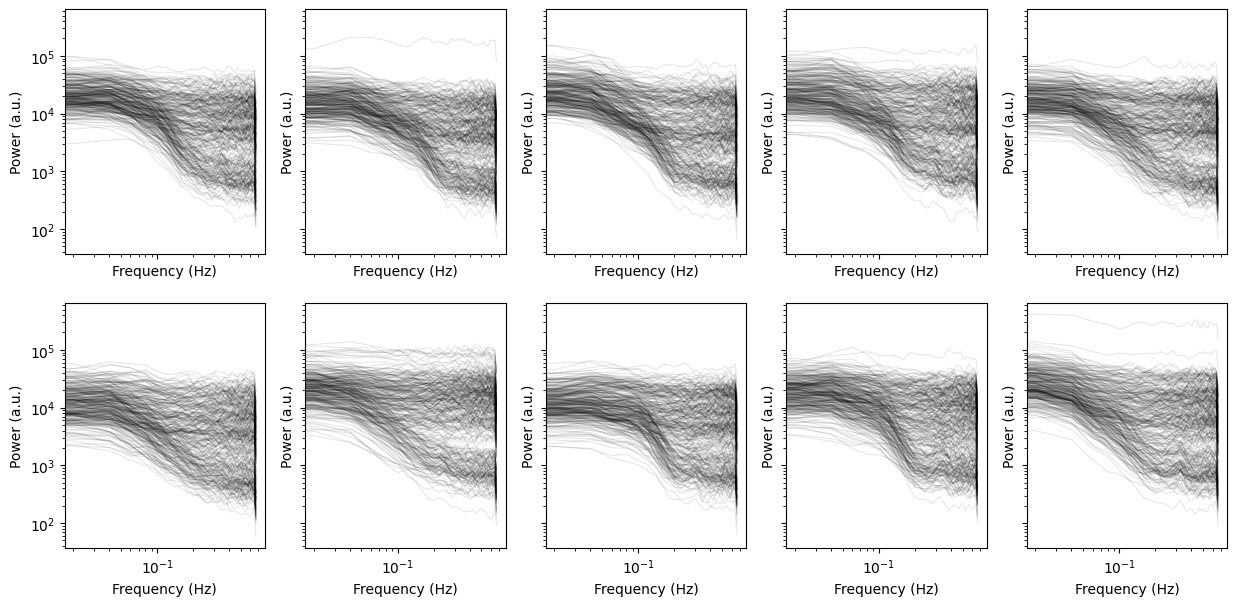

In [2]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7), sharex=True, sharey=True)
axs = axs.flatten()  # type: ignore

for X, ax in zip(Xs, axs):
    """plot the PSD of the timeseries per region"""
    freqs, powers = spectral.compute_spectrum(X, sampling_rate, nperseg=int(sampling_rate * 50))

    ax.loglog(np.tile(freqs, (n_regions, 1)).T, powers.T, color="k", lw=0.75, alpha=0.1)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power (a.u.)")


/var/folders/kk/_kp50ntn3xb5_kv9_m3q3sw80000gn/T/ipykernel_1712/3563945009.py:17: RuntimeWarning: overflow encountered in exp
  return np.exp(-x / tau)


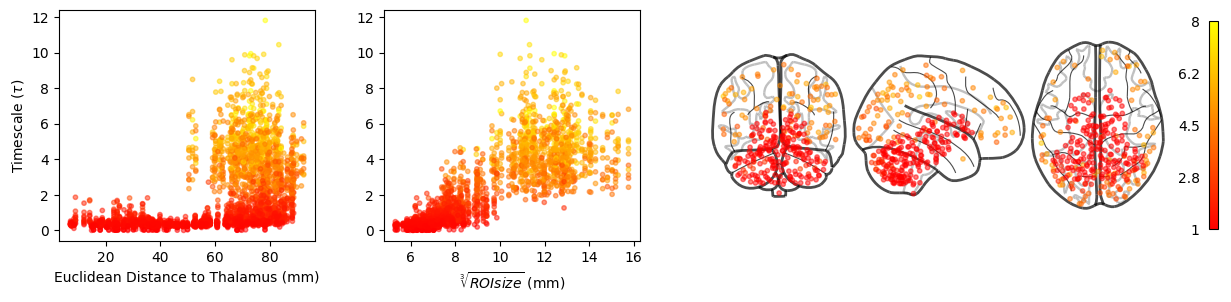

In [3]:
center = [0, -12, 4]  # thalamus coordinates
hcp_coordinates = np.load("./data/nregions-300_coordinates.npy")
hcp_sizes = np.load("./data/nregions-300_sizes.npy")

# euclidean distance to the thalamus (brain center)
distances = np.linalg.norm(hcp_coordinates - center, axis=1)

timescales = np.array(
    [calc_timescale(acf_utils.acf_fft(X, n_timepoints), n_timepoints) for X in Xs]
)

# plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw=dict(width_ratios=[0.5, 0.5, 1]))

for timescale in timescales:
    axs[0].scatter(distances, timescale, alpha=0.5, s=10, c=timescale, cmap="autumn")

axs[0].set_xlabel(f"Euclidean Distance to Thalamus (mm)")
axs[0].set_ylabel(r"Timescale ($\tau$)")

for timescale in timescales:
    axs[1].scatter(hcp_sizes, timescale, alpha=0.5, s=10, c=timescale, cmap="autumn")

axs[1].set_xlabel(r"$\sqrt[3]{ROIsize}$ (mm)")

plotting.plot_markers(
    timescales.mean(axis=0),
    hcp_coordinates,
    axes=axs[2],
    node_cmap="autumn",
    alpha=0.5,
    node_vmin=1,
    node_vmax=8,
    node_size=10,
    annotate=False,
)
